<a href="https://colab.research.google.com/github/dastronmighty/g-colab/blob/main/Visualize_and_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q hiddenlayer

In [19]:
import time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd #for good luck (who knows we might need it)

# The Golden Child
import torch

from torch import nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import hiddenlayer as hl


from IPython.core.debugger import set_trace

BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS=10

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 7, 9,  ..., 2, 9, 5])
torch.Size([19999, 784])
tensor(0) tensor(9)


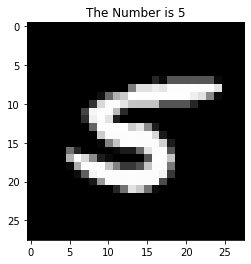

In [20]:
mnist_test = pd.read_csv("/content/sample_data/mnist_test.csv")
mnist_train = pd.read_csv("/content/sample_data/mnist_train_small.csv")
y_test_ = mnist_test.values[:,0].astype(int)
x_test_ = mnist_test.values[:,1:].astype(float)
y_train_ = mnist_train.values[:,0].astype(int)
x_train_ = mnist_train.values[:,1:].astype(float)
x_train = torch.tensor(x_train_, dtype=torch.float)
y_train = torch.tensor(y_train_, dtype=torch.long)
x_test = torch.tensor(x_test_, dtype=torch.float)
y_test  = torch.tensor(y_test_, dtype=torch.long)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

idx = np.random.randint(0, x_train_.shape[0]) - 9
x = plt.title("The Number is "+str(y_train_[idx]))
x = plt.imshow(x_train_[idx].reshape((28, 28)), cmap="gray")


In [25]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  history = []
  for epoch in range(epochs):
    t1 = int(time.time() * 1000) 
    model.train()
    tlosses, tnums = zip(
        *[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl]
      )
    model.eval()
    with torch.no_grad():
      losses, nums = zip(
        *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
    train_loss = np.sum(np.multiply(tlosses, tnums)) / np.sum(tnums)
    train_acc = np.array([accuracy(model(xb), yb).item() for xb, yb in train_dl]).mean()
    val_acc = np.array([accuracy(model(xb), yb).item() for xb, yb in valid_dl]).mean()
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    t_ex = round((int(time.time() * 1000) ) - t1, 0)
    history.append({
        "epoch": epoch,
        "train_acc": train_acc,
        "train_loss": train_loss,
        "val_acc": val_acc,
        "val_loss": val_loss,
        "time": t_ex
    })
    print(f"Epoch: {epoch+1}\tVal. Loss: {val_loss}\tVal. Acc. {val_acc}\tTime {t_ex}ms")
  return history

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess_nogpu(x, y):
    return x.view(-1, 1, 28, 28), y

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [26]:
loss_func = F.cross_entropy 

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_test, y_test)
train_dl, valid_dl = get_data(train_ds, valid_ds, BATCH_SIZE)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

model.to(dev)
opt = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

cnnhistgpu = fit(EPOCHS, model, loss_func, opt, train_dl, valid_dl)

Epoch: 1	Val. Loss: 0.6735810263119455	Val. Acc. 0.8035403482521637	Time 5220ms
Epoch: 2	Val. Loss: 0.4140733826150297	Val. Acc. 0.8826147151898734	Time 5335ms
Epoch: 3	Val. Loss: 0.360512714317762	Val. Acc. 0.8973496835443038	Time 6161ms
Epoch: 4	Val. Loss: 0.3316141818725046	Val. Acc. 0.9071400316455697	Time 5284ms
Epoch: 5	Val. Loss: 0.29924720537738214	Val. Acc. 0.9196004746835443	Time 5226ms
Epoch: 6	Val. Loss: 0.27734303616504424	Val. Acc. 0.9217761075949367	Time 5151ms
Epoch: 7	Val. Loss: 0.2601038596060726	Val. Acc. 0.9261273734177216	Time 5134ms
Epoch: 8	Val. Loss: 0.23762093476987634	Val. Acc. 0.9319620253164557	Time 5120ms
Epoch: 9	Val. Loss: 0.2271917060416977	Val. Acc. 0.9357199367088608	Time 5102ms
Epoch: 10	Val. Loss: 0.20450340674826653	Val. Acc. 0.9401700949367089	Time 5113ms


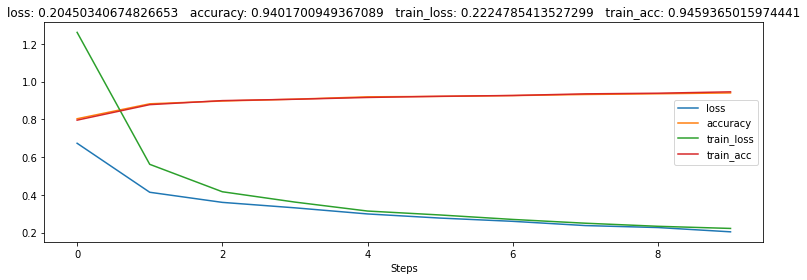

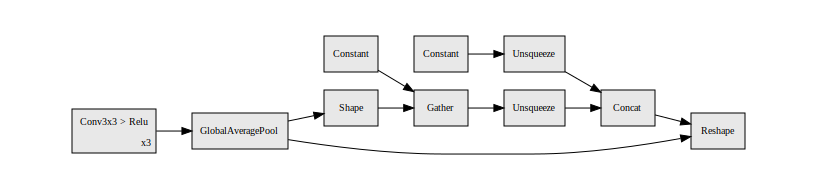

In [37]:
train_dl, valid_dl = get_data(train_ds, valid_ds, BATCH_SIZE)
valid_dl = WrappedDataLoader(valid_dl, preprocess_nogpu)
model.to('cpu')
inputs, classes = next(iter(valid_dl))
y = model(inputs)
model_history = hl.History()
model_canv = hl.Canvas()
for h in cnnhistgpu:
  model_history.log(step=h["epoch"], loss=h["val_loss"], accuracy=h["val_acc"], train_loss=h["train_loss"], train_acc=h["train_acc"])
with model_canv:
    model_canv.draw_plot([model_history["loss"], model_history["accuracy"], model_history["train_loss"],model_history["train_acc"] ])
hl.build_graph(model, torch.zeros([16, 1, 3, 3]))